# Credit Card Transactions Fraud Detection

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
from joblib import dump, load

Helper **Functions**

In [37]:
# Calculate and plot confusion matrix
def plot_confusion_matrix(y_test, y_prediction):
    conf_matrix = confusion_matrix(y_test, y_prediction)
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [38]:
# Function for ploting the roc_curve
def plot_roc_curve(y_test, y_proba):
    fpr, tpr, thrasholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

**Import the training datafram**

In [39]:
df = pd.read_csv('data/fraudTrain.csv')
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


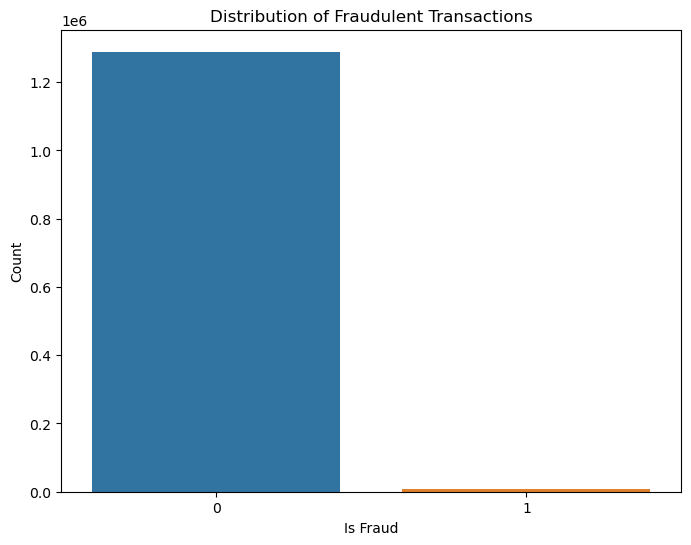

In [40]:
plt.figure(figsize=(8, 6))
sns.countplot(x = df['is_fraud'])
plt.title('Distribution of Fraudulent Transactions')
plt.xlabel('Is Fraud')
plt.ylabel('Count')
plt.show()

Creating a Pipeline

In [41]:
categorical_cols = ['gender', 'category', 'state']
numerical_cols = ['amt', 'lat', 'long','city_pop', 'unix_time', 'merch_lat', 'merch_long']

cat_transform = Pipeline(steps = [('oneHot', OneHotEncoder(drop='first' , handle_unknown='ignore'))])
num_transform = Pipeline(steps = [('robust', RobustScaler())])

preprocessing = ColumnTransformer(transformers = [
    ('num', num_transform, numerical_cols),
    ('cat', cat_transform, categorical_cols)
])

pip = Pipeline(steps = [('process', preprocessing)])

#### Balance the data

In [42]:
fraud = df[df['is_fraud'] == 1]
not_fraud = df[df['is_fraud'] == 0].sample(fraud.shape[0])
# Concatenate the dataframes
combined_df = pd.concat([fraud, not_fraud])

# Shuffle the combined dataframe
shuffled_df = combined_df.sample(frac=1).reset_index(drop=True)

In [43]:
shuffled_df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,499268,2019-08-05 04:10:13,2512312531485080,fraud_Schmitt Inc,gas_transport,85.84,John,Mccormick,M,79414 Clark Lakes Suite 966,...,42.5164,-82.9832,134056,"Producer, radio",1956-10-08,d7330e3406b0e0fec4078a0f8b6e7770,1344139813,42.254933,-83.938024,0
1,81563,2019-02-18 00:18:41,3540210836308425,fraud_Kilback LLC,grocery_pos,283.61,Steven,Yoder,M,94975 David Mews Apt. 316,...,34.7437,-102.5064,53,Fisheries officer,1992-06-19,17f7d14185cb131c6c900424a54f90c7,1329524321,33.747366,-101.864511,1
2,254875,2019-05-06 19:52:18,675961917837,"fraud_Roberts, Daniel and Macejkovic",kids_pets,25.50,Christopher,Cummings,M,478 George Course Apt. 056,...,40.6267,-96.7456,142,Chiropodist,1967-08-24,8a677ad79df30652fd4ae215d642a55f,1336333938,41.077912,-95.894658,0
3,815701,2019-12-08 02:19:25,4538566639857,"fraud_Heller, Gutmann and Zieme",grocery_pos,51.35,Jerry,Kelly,M,3539 Mckenzie Stream,...,40.8170,-74.0000,13835,"Programmer, multimedia",1967-05-28,bebbf8adb41699dfc55597368a51fcfe,1354933165,40.042740,-73.039334,0
4,102654,2019-03-01 04:06:47,4810789809665942990,fraud_Miller-Harris,misc_net,114.17,Julie,Sanchez,F,916 Charles Road,...,39.5756,-83.7153,338,Quantity surveyor,1988-07-28,7f0ac66622c96b07ebd27300300a639d,1330574807,39.869169,-84.497032,0


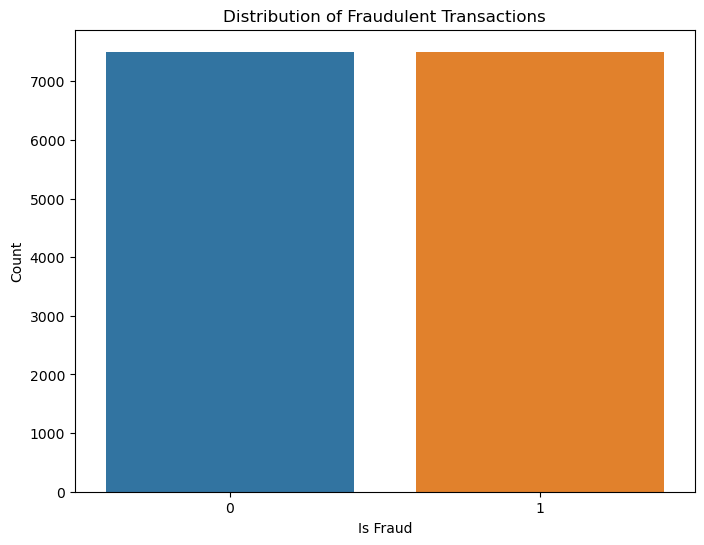

In [44]:
plt.figure(figsize=(8, 6))
sns.countplot(x = shuffled_df['is_fraud'])
plt.title('Distribution of Fraudulent Transactions')
plt.xlabel('Is Fraud')
plt.ylabel('Count')
plt.show()

In [45]:
X = shuffled_df.drop(columns = 'is_fraud')
y = shuffled_df['is_fraud']

In [46]:
X_pip = pip.fit_transform(X)

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X_pip, y, test_size = .3, random_state = 42)

In [48]:
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

C:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

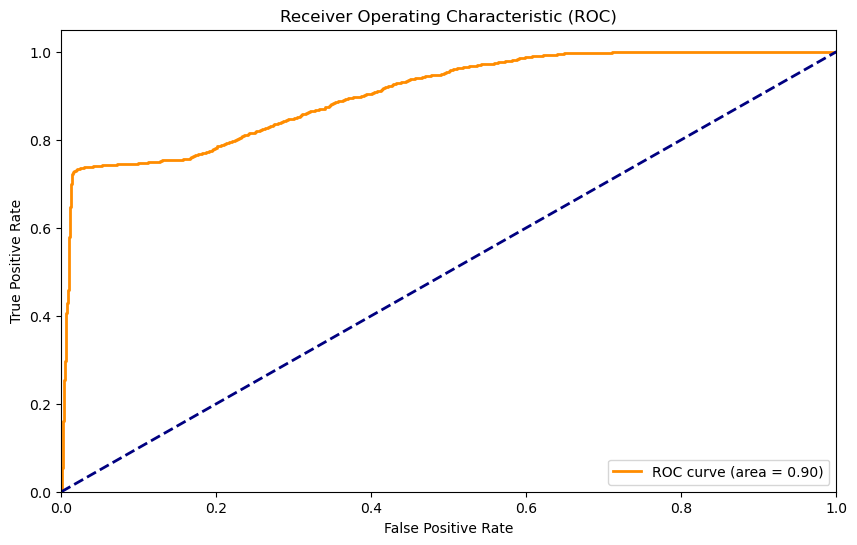

In [49]:
y_proba = logistic_model.predict_proba(X_test)[:,1]
plot_roc_curve(y_test, y_proba)

In [50]:
y_pred = np.where(y_proba > .5, 1, 0)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.88      0.83      2265
           1       0.86      0.75      0.80      2239

    accuracy                           0.82      4504
   macro avg       0.82      0.82      0.81      4504
weighted avg       0.82      0.82      0.81      4504



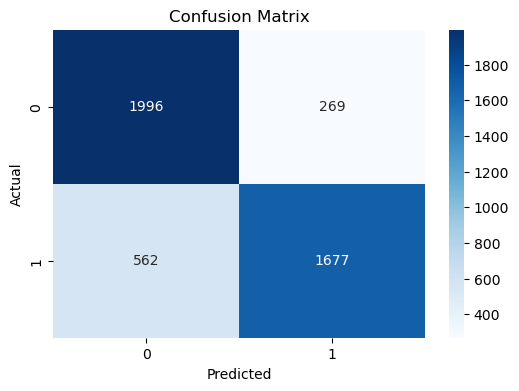

In [51]:
plot_confusion_matrix(y_test, y_pred)

In [52]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_proba_rf = rf.predict_proba(X_test)[:,1]

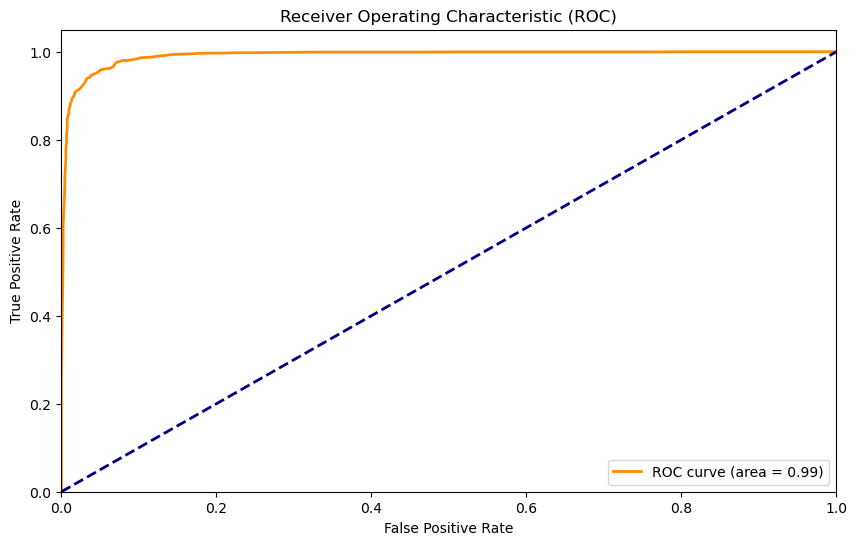

In [53]:
plot_roc_curve(y_test, y_proba_rf)

In [54]:
y_pred_rf = np.where(y_proba_rf > .5, 1, 0)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      2265
           1       0.97      0.93      0.95      2239

    accuracy                           0.95      4504
   macro avg       0.95      0.95      0.95      4504
weighted avg       0.95      0.95      0.95      4504



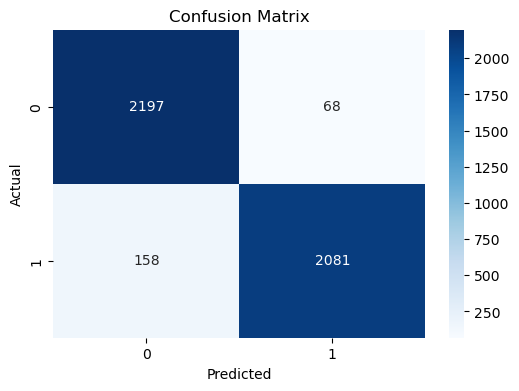

In [55]:
plot_confusion_matrix(y_test, y_pred_rf)

In [56]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
y_proba_tree = tree.predict_proba(X_test)[:,1]

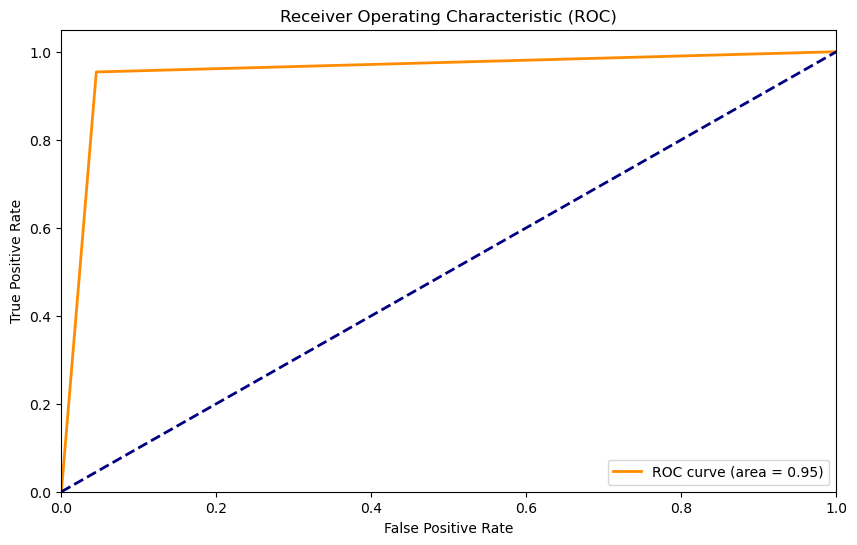

In [57]:
plot_roc_curve(y_test, y_proba_tree)

In [58]:
report = classification_report(y_test, y_proba_tree)
print(report)

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      2265
           1       0.95      0.95      0.95      2239

    accuracy                           0.95      4504
   macro avg       0.95      0.95      0.95      4504
weighted avg       0.95      0.95      0.95      4504



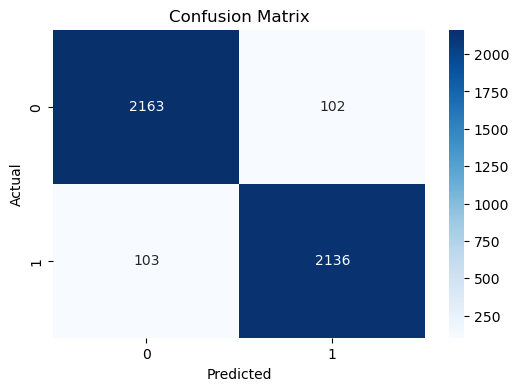

In [59]:
plot_confusion_matrix(y_test, y_proba_tree)

***Compare the models***

In [60]:
# Define model names and instances
model_names = ['Logistic Regression', 'Decision tree' , 'Random Forest']
model_instances = [logistic_model, tree, rf]

# Initialize lists to store accuracy and ROC scores
accuracy_scores = []
roc_scores = []
f1_scores = []
precision_scores = []
recall_scores = []

# Calculate accuracy and ROC scores for each model
for model in model_instances:
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    roc_score = roc_auc_score(y_test, predictions)
    accuracy_scores.append(accuracy)
    roc_scores.append(roc_score)
    f1_scores.append(f1_score(y_test, predictions))
    precision_scores.append(precision_score(y_test, predictions))
    recall_scores.append(recall_score(y_test, predictions))

# Creating a DataFrame to compare results
results_df = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracy_scores,
    'ROC Score': roc_scores,
    'F1 Score': f1_scores,
    'Precision Score': precision_scores,
    'Recall Score': recall_scores,
})

# the comparison table
results_df

,Model,Accuracy,ROC Score,F1 Score,Precision Score,Recall Score
0,Logistic Regression,0.815497,0.815116,0.801434,0.861768,0.748995
1,Decision tree,0.954485,0.954482,0.954210,0.954424,0.953997
2,Random Forest,0.949822,0.949705,0.948496,0.968357,0.929433


***We'll opt for the Random Forest classifier to train it using all the available training data. Then, we'll import the testing data to evaluate its performance on new, unseen data.***

In [61]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_pip, y)

RandomForestClassifier(random_state=42)

In [62]:
test_df = pd.read_csv("data/fraudTest.csv")
test_df.dropna(inplace = True)

In [63]:
XTest = test_df.drop(columns = 'is_fraud')
yTest = test_df['is_fraud']
X_test_pip = pip.transform(XTest)

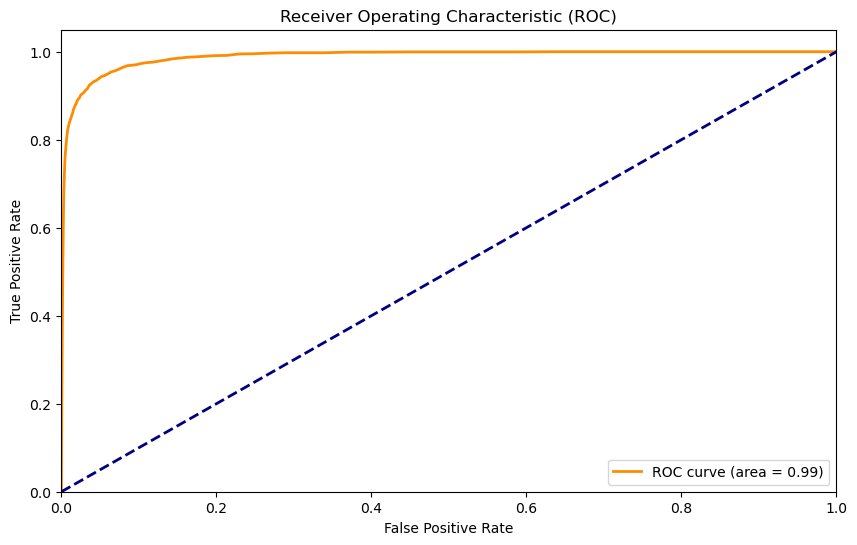

In [64]:
yProba = rf_model.predict_proba(X_test_pip)[:,1]
plot_roc_curve(yTest, yProba)

In [65]:
y_prediction = np.where(yProba > .6, 1, 0)
print(f"Accuraccy = {accuracy_score(yTest, y_prediction)*100:.2f}%")

Accuraccy = 98.29%


In [66]:
# Save the model
dump(rf_model, 'random_forest_model.joblib')
# Save the pipeline and model
dump(pip, 'pipeline.joblib')

['pipeline.joblib']

In [67]:
# Function to load model and the pipeline to make predictions

def load_model_and_predict(data):
    # Load the saved pipeline and the model
    loaded_pipeline = load('pipeline.joblib')
    loaded_model = load('random_forest_model.joblib')

    # Preprocess the data using the loaded pipeline
    preprocessed_data = loaded_pipeline.transform(data)

    # Perform predictions using the loaded model
    proba = loaded_model.predict_proba(preprocessed_data)[:,1]
    predictions = np.where(proba > .6 , 1, 0)

    return predictions
